# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to fit a logarithm. We will also use this demonstrator to show what happens if a QNN, that was trained on a noiseless simulator is executed on a noisy simulator.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA

We will use Qiskit's `StatevectorSimulator` for trainning.

In [2]:
executor = Executor("statevector_simulator")

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

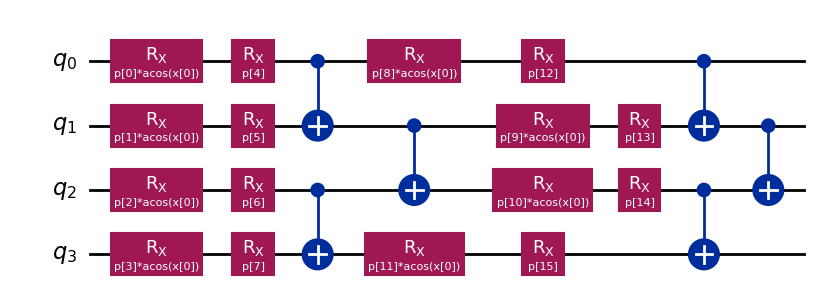

In [3]:
nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

We also need an observable

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), SLSQP(), param_ini, param_op_ini)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)

fit: 100%|██████████| 100/100 [02:02<00:00,  1.21s/it]

## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 0.91858145 -1.1163345   0.38467092  1.39597102  1.10224011  2.41369111
  1.64968778 -0.81903595  0.4867727   0.38505193  1.10635672  0.72867129
 -1.74881862 -0.64411871  0.86344117 -0.91471452]
Result operator params: [-0.47157523  5.10755673  2.63075629]


Also let's plot the predicted function vs. the actual logarithm function

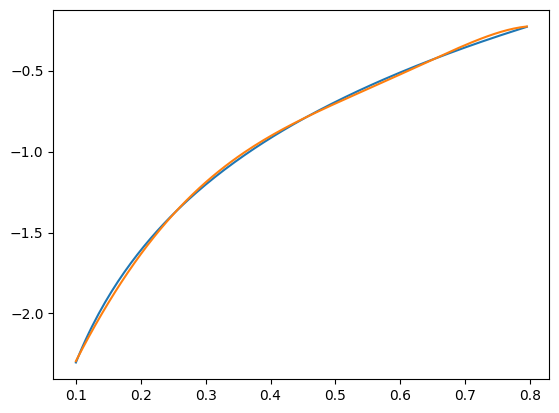

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

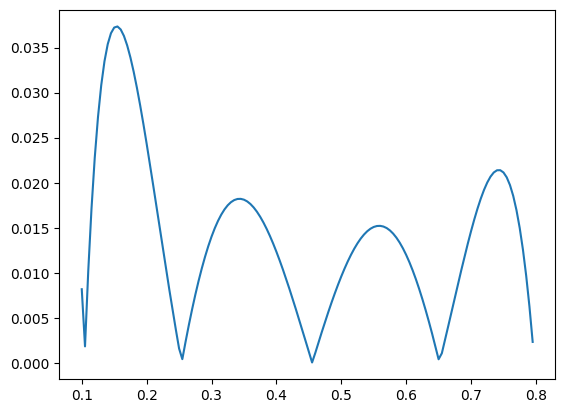

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

## Evaluation on noisy simulator

Finally let's evaluate the trained `QNNRegressor` on Qiskit's `QasmSimulator`.

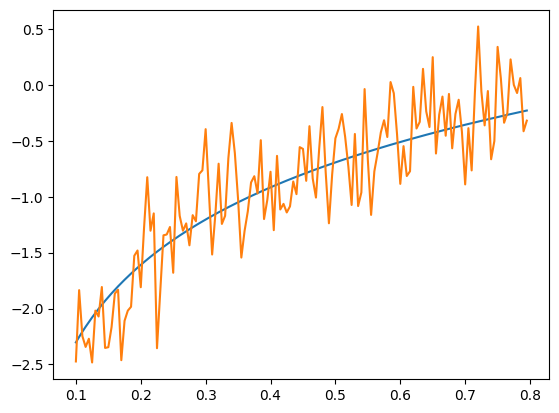

In [10]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(pqc, ising_op, qasm, SquaredLoss, SLSQP(), reg.param, reg.param_op)
qnn_qasm._is_fitted = True
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

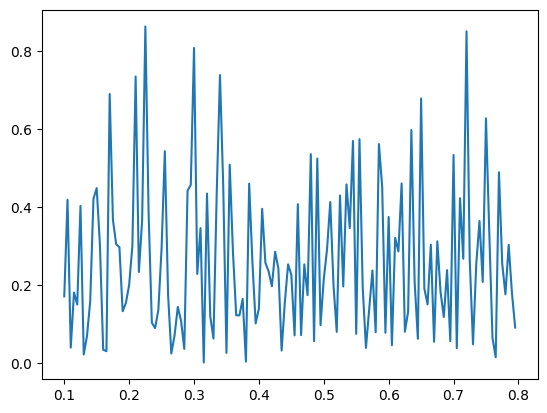

In [11]:
plt.plot(x, np.abs(y - np.log(x)))

We see, that the model is now subject to noise.